### Download The North Dakota Monthly Production Report and prepare dataframe for visualzations

This Jupyter notebook will download Oil and Gas production volumes from North Dakota Industrial Commission (NDIC). 
NDIC publishes ND state Oil and Gas production report every month.  This report will contain production volume from each well within ND Oil and Gas fields.<br><br>
These reports are available in PDF format for public access. NDIC started publishing these reports in Excel format as well starting from May 2015.<br><br>
We will download PDF reports starting from Jan 2009 to April 2015, and Excel spreadsheets starting from May 2015 to December 2019.

#### Output from this Jupyter Notebook
1. <b>NDYearlyAggProductionVolumes.csv</b> - Aggregated production volume by the report year and company

In [1]:
import pandas as pd
import wget
import re
import datetime

Download Oil and Gas production volumes of North Dakota facilities from NDIC website.
* Website address: https://www.dmr.nd.gov/oilgas/mprindex.asp

In [2]:
base_url='https://www.dmr.nd.gov/oilgas/mpr/'
target_folder='./NDIC_ProductionData/'
sourceDir='./NDIC_ProductionData/'

```python
#Download PDF files
years = range(2009, 2016,1)
months=range(1,13,1)
for year in years:
    for month in months:
        fileName=str(year)+'_'+('0'+str(month))[-2:]+'.pdf'
        url=base_url+fileName
        target_file = target_folder+fileName
        wget.download(url, target_file)
```

###### Code to parse pdf containing TABULA library
```python
import tabula as tb
df = tb.read_pdf("./Additional Datasets/2015_05.pdf", pages='all')
df_200901 = tb.read_pdf("https://www.dmr.nd.gov/oilgas/mpr/2009_01.pdf", pages=[3])
len(df_200901)
df_200901[0]
```

This library is messing up the table structure and loosing several column values, so we need to find an alternative way to properly parse the PDF files

We will use XpdfReder to convert these pdf files into text files, and then we will use regular expressions to parse the text files

###### Converting PDF into Text files
* Converting PDF files into text files using pdftotext tool.
* download link: https://xpdfreader-dl.s3.amazonaws.com/xpdf-tools-win-4.02.zip
* Website: https://www.xpdfreader.com/download.html

In [4]:
# a sample command and test of pdftotext.ext
from subprocess import check_output
command=['C:/Users/rafeeshaik/Downloads/xpdf-tools-win-4.02/bin32/pdftotext.exe',
 '-f',
 '3',
 '-simple',
target_folder+'2009_01.pdf'
]
check_output(command)

b''

In [3]:
# Prepare windows command list for each file
from subprocess import check_output
years = range(2009, 2016, 1)
months = range(1, 13, 1)
commList=[]
for year in years:
    for month in months:
        if (year==2015 and month>4):
            break
        input_fileName = target_folder+str(year)+'_'+ ('0'+str(month))[-2:]+'.pdf'
        comm=[]
        comm.append('C:/Users/rafeeshaik/Downloads/xpdf-tools-win-4.02/bin32/pdftotext.exe')
        comm.append('-f')
        comm.append('3')
        comm.append('-simple')
        comm.append(input_fileName)
        commList.append(comm)
        #print(input_fileName)

# Now execute the windows OS command from python 
for comm in commList:
    check_output(comm)        

##### Code to download pdf and excel spreadsheets

```python
#Download Excel files
years = range(2015, 2020,1)
months=range(1,13,1)
for year in years:
    for month in months:
        fileName=str(year)+'_'+('0'+str(month))[-2:]+'.xlsx'
        url=base_url+fileName
        target_file = target_folder+fileName
        wget.download(url, target_file)
```        

##### ignore if line contains 
1. page breaks - 'Page '
2. TOTAL :
3. POOL TOTAL :

###### Company Name: 
* from 0 start to 68 characters
* Formation: 69 till end of the line

###### Well name:
* starts with three spaces
* well_Name = 3 to 56
* Location = 56 to  73
* County = 73 to 80
* File = 80 to 87
* Oil = 87 to 93
* Wtr = 93 to 102
* Days = 101 to 109
* Runs = 109 to 117
* Gas = 117 to 125
* Gas_Sold=125 to the end

##### Using fixed length file parsing logic

```python
target_folder='D:/temp/NDIC_ProductionData/'
test_file='2015_05.txt'
cols = ['COMPANY', 'FORMATION', 'WELL_NAME', 'LOCATION', 'COUNTY', 'FILE', 'OIL', 'WATER', 'DAYS', 'RUNS', 'GAS', 'GAS_SOLD']
df = pd.DataFrame(columns = cols)
COMPANY=''
FORMATION=''
re
with open(target_folder+test_file) as fp:
    while True:
        line = fp.readline()
        #print(line)
        #df_temp=pd.DataFrame(columns=cols)
        if ('Page ' in line) or ('TOTAL :' in line) or ('POOL TOTAL :' in line) or ('Well Name' in line):
            #print('skipping the line')
            continue
        elif (line[:3]!='   '):
            #print('This is company')
            COMPANY=line[:68].strip()
            if(line[68:].strip()!=''):
                FORMATION = line[68:-2].strip()
            #print('compis=',COMPANY.strip(), 'formation is=',FORMATION.strip())

        else:
            #print('this is well line')
            #print(line)
            df_temp={}
            df_temp['COMPANY'] = COMPANY
            df_temp['FORMATION'] = FORMATION
            df_temp['WELL_NAME'] = line[3:55].strip()
            df_temp['LOCATION'] = line[55:72].strip()
            df_temp['COUNTY'] = line[72:79].strip()
            df_temp['FILE'] = line[79:84].strip()
            df_temp['OIL'] = line[85:93].strip()
            df_temp['WATER'] = line[93:102].strip()
            df_temp['DAYS'] = line[101:109].strip()
            df_temp['RUNS'] = line[109:117].strip()
            df_temp['GAS'] = line[117:125].strip()
            df_temp['GAS_SOLD'] = line[125:133].strip()
            #print(df_temp)
            
            if(df_temp['WELL_NAME']==''):
                continue
            if(len(df)==0):
                df=pd.DataFrame([df_temp])
            else: 
                df=df.append(pd.DataFrame([df_temp]))
        if not line:
            break
```            

###### Parsing using regular expressions

In [4]:
print(datetime.datetime.now())

cols = ['COMPANY', 'FORMATION', 'WELL_NAME', 'LOCATION', 'COUNTY', 'FILE', 'OIL', 'WATER', 'DAYS', 'RUNS', 'GAS', 'GAS_SOLD']

pattern = """
    (^\s{3})
    (?P<WELL_NAME>[`'%}{/:\w ,-.\d#&()"]+) # Well Name
    (\s{6,})
    (?P<LOCATION>[-CSEWNLOT/\d\s]*) # Location
    (\s{1,})
    (?P<COUNTY>[\w]*) # County
    (\s{1,})
    (?P<FILE>[\d]*) # File
    (\s{1,})
    (?P<OIL>[-\d\w]+) # Oil
    (\s{1,})
    (?P<WATER>[-\d\w]+) # Water
    (\s{1,})
    (?P<DAYS>[-\d\w]+) # Days
    (\s{1,})
    (?P<RUNS>[-\d\w]+) # Runs
    (\s{1,})
    (?P<GAS>[-\d\w]+) # Gas
    (\s{1,})
    (?P<GAS_SOLD>[-\d\w]+) # Gas Sold
    """
#Prepare file name list
years = range(2009, 2016, 1)
months = range(1, 13, 1)
inputFileList=[]
for year in years:
    for month in months:
        if (year==2015 and month>4):
            break
        input_fileName = target_folder+str(year)+'_'+ ('0'+str(month))[-2:]+'.txt'
        inputFileList.append(input_fileName)
#print(inputFileList)
#This list will hold the output dataframes
out_df_list=[]

#Iterate through each file and parse it into dataframe        
for input_file in inputFileList:

    #df = pd.DataFrame(columns = cols)
    COMPANY=''
    FORMATION=''
    debug_file = input_file.split('.')[0]+'_debug'+'.txt'
    debug_f = open(debug_file, "w")
    #print(input_file,'->',debug_file)
    rowList = []
    
    with open(input_file) as fp:
        for cnt, line in enumerate(fp):

            #print(line)
            if ('Page ' in line) or ('POOL TOTAL :' in line) or ('Well Name' in line) or len(line.strip())<3 or line[0:5]=='TOTAL':
                #print('skipping the line')
                continue
            elif (line[:3]!='   '):
                #print('This is company')
                COMPANY=line[:55].strip()
                if(line[55:].strip()!=''):
                    FORMATION = line[55:-2].strip()
                #print('compis=',COMPANY.strip(), 'formation is=',FORMATION.strip())

            else:
                #print('this is well line')
                #print(line)
                debug_f.write(line)
                for item in re.finditer(pattern,line,re.VERBOSE):
                    dict_temp=item.groupdict()
                    dict_temp['COMPANY'] = COMPANY
                    dict_temp['FORMATION'] = FORMATION
                    dict_temp['REPORTED_ON'] = input_file.split('/')[-1].split('.')[0]
                    dict_temp['WELL_NAME']=dict_temp['WELL_NAME'].strip()
                    rowList.append(dict_temp)
                    debug_f.write('Added well record to list')
                    #print('Added well record to list')
    debug_f.close()
    #pd.DataFrame(rowList).to_csv(input_file.split('.')[0]+'.csv',sep='|')
    out_df_list.append(pd.DataFrame(rowList))
    
print(len(out_df_list))
print(datetime.datetime.now()) 

2020-05-15 19:18:22.937323
76
2020-05-15 19:36:07.497459


###### Prepare a dataframe that contains data from all PDF files

In [5]:
all_pdfData = pd.concat(out_df_list)
all_pdfData=all_pdfData.reset_index().drop('index',axis=1)

In [6]:
all_pdfData.sample(5)

,WELL_NAME,LOCATION,COUNTY,FILE,OIL,WATER,DAYS,RUNS,GAS,GAS_SOLD,COMPANY,FORMATION,REPORTED_ON
458090,TANGSRUD 10-1H2,LOT2 1 160 96,DIV,24966,1364,2856,31,1355,3991,3955,"CONTINENTAL RESOURCES, INC.",HAYLAND - BAKKE,2014_12
391867,MOCCASIN CREEK 13-34-28-1H,SWSW 34 148 93,DUN,18707,5025,2834,30,4922,3811,2774,KODIAK OIL & GAS (USA) INC.,MOCCASIN CREEK - BAKKE,2014_06
120400,OAS 31-161-92H,LOT 1 31 161 92,BRK,16810,552,144,31,132,834,0,SAMSON RESOURCES COMPANY,FOOTHILLS - BAKKE,2011_07
492391,MONTAGUE 5601 42-34 #4T,SESW 34 156 101,WIL,26058,1,33,20,1,243,0,OASIS PETROLEUM NORTH AMERICA LLC,COW CREEK - BAKKE,2015_03
89061,SEVERANCE 1-9-4H,SESW 9 153 89,MTL,18325,11101,2274,31,10694,2186,0,HUNT OIL COMPANY,PARSHALL - BAKKE,2010_12


###### Make a hard copy of the dataframe so that we dont loose original dataframe by accedent

In [7]:
df=all_pdfData.copy()
df.to_csv(target_folder+'AllPDFFiles_RAWData.csv',sep='|')

###### Cleaning efforts
1. Replace TR and SI and '-' in gas and oil volumn colums with Zero
2. Split the REPORT_NO column into year and month columns

In [8]:
#Convert to float values
df[['OIL', 'WATER', 'DAYS','RUNS', 'GAS', 'GAS_SOLD']]=df[['OIL', 'WATER', 'DAYS','RUNS', 'GAS', 'GAS_SOLD']].astype(str).replace(r'[-a-zA-Z]+','-0',regex=True).astype(float)
#Split into report year and month
df[['REPORT_YEAR','REPORT_MONTH']]=df['REPORTED_ON'].str.extract('(?P<REPORT_YEAR>\d+)_(?P<REPORT_MONTH>\d+)')

In [9]:
df.sample(5)

,WELL_NAME,LOCATION,COUNTY,FILE,OIL,WATER,DAYS,RUNS,GAS,GAS_SOLD,COMPANY,FORMATION,REPORTED_ON,REPORT_YEAR,REPORT_MONTH
423554,EDWARD GOODBIRD 9HD,NWNW 9 149 91,DUN,22828,1692.0,586.0,30.0,1850.0,1116.0,0.0,"WPX ENERGY WILLISTON, LLC",HEART BUTTE - BAKKE,2014_09,2014,09
484934,KULLAND 1-30H,SWSE 30 154 89,MTL,17145,1311.0,292.0,28.0,1328.0,857.0,407.0,HUNT OIL COMPANY,PARSHALL - BAKKE,2015_02,2015,02
449375,WALLA 13X-19H,LOT4 19 151 99,MCK,25518,5538.0,2623.0,25.0,5473.0,7239.0,4141.0,SM ENERGY COMPANY,POE - BAKKE,2014_11,2014,11
20116,JUDSON CONDENSATE STATION,10 153 102,WIL,50276,201.0,0.0,0.0,452.0,-0.0,-0.0,BEAR PAW ENERGY INC.,RECOVERED LIQUIDS FROM GAS LINE,2009_06,2009,06
381176,VOIGT 24-21H,NENW 24 148 94,DUN,17009,1165.0,333.0,31.0,1111.0,770.0,770.0,ENERPLUS RESOURCES USA CORPORATION,MCGREGORY BUTTES - BAKKE,2014_05,2014,05


###### Save this data into a CSV file for analysis

In [10]:
df.to_csv(target_folder+'AllPDFFilesData.csv',sep='|')

In [11]:
# basic data verification
(1309282402.0, 1501234802.0)
df['OIL'].sum(), df['GAS'].sum()

(1309282402.0, 1501234802.0)

In [12]:
# Data verification
df.groupby (['COMPANY']).sum().sort_values('OIL', ascending=False).head(10)

,OIL,WATER,DAYS,RUNS,GAS,GAS_SOLD
COMPANY,,,,,,
"CONTINENTAL RESOURCES, INC.",152863899.0,145515947.0,1405128.0,159805097.0,224876637.0,157063357.0
WHITING OIL AND GAS CORPORATION,126288143.0,111674658.0,1192376.0,149539845.0,126700636.0,116485934.0
"EOG RESOURCES, INC.",105367895.0,43593185.0,720630.0,129389090.0,79232456.0,60188411.0
BURLINGTON RESOURCES OIL & GAS COMPANY LP,80353170.0,117741328.0,487973.0,81321232.0,82218280.0,61215753.0
HESS CORPORATION,70414288.0,101246904.0,886192.0,74508707.0,151454840.0,124422925.0
MARATHON OIL COMPANY,65840363.0,26291980.0,533682.0,69611597.0,51189480.0,30629380.0
XTO ENERGY INC.,59277916.0,34454378.0,556705.0,61260455.0,80476560.0,54252403.0
"HESS BAKKEN INVESTMENTS II, LLC",52622501.0,37440890.0,472366.0,52913927.0,84507111.0,61442919.0
OASIS PETROLEUM NORTH AMERICA LLC,44640407.0,49305217.0,420628.0,54662514.0,40721983.0,35512049.0


##### Testbed

In [179]:
tst_str="   FLAT TOP BUTTE FED. COM. 100%     2                  SWNW     30 146 101 MCK    13344    57        0     17       0      70        0"

pattern = """
(^\s{3})
(?P<WELL_NAME>[`'%/}{:\w ,-.\d#&()"]+) # Well Name
(\s{7,})
(?P<LOCATION>[-CSEWNLOT/\d\s]*) # Location
(\s{1,})
(?P<COUNTY>[\w]*) # County
(\s{1,})
(?P<FILE>[\d]*) # File
(\s{1,})
(?P<OIL>[-\d\w]+) # Oil
(\s{1,})
(?P<WATER>[-\d\w]+) # Water
(\s{1,})
(?P<DAYS>[-\d\w]+) # Days
(\s{1,})
(?P<RUNS>[-\d\w]+) # Runs
(\s{1,})
(?P<GAS>[-\d\w]+) # Gas
(\s{1,})
(?P<GAS_SOLD>[-\d\w]+) # Gas Sold
"""
for item in re.finditer(pattern,tst_str,re.VERBOSE):
    # We can get the dictionary returned for the item with .groupdict()
    print(item.groupdict())


{'WELL_NAME': 'FLAT TOP BUTTE FED. COM. 100%     2           ', 'LOCATION': 'SWNW     30 146 101', 'COUNTY': 'MCK', 'FILE': '13344', 'OIL': '57', 'WATER': '0', 'DAYS': '17', 'RUNS': '0', 'GAS': '70', 'GAS_SOLD': '0'}


###### Parse production volumes data from Excel spreadsheets to Pandas dataframes

In [13]:
years = range(2015, 2020, 1)
months = range(1, 13, 1)
inputFileList=[]
outDFList=[]
#Prepare file list
for year in years:
    for month in months:
        if (year==2015 and month<=4):
            continue
        input_fileName = sourceDir+str(year)+'_'+ ('0'+str(month))[-2:]+'.xlsx'
        inputFileList.append(input_fileName)

#print(inputFileList)        
for inputfile in inputFileList:
    dfDict = pd.read_excel(inputfile, sheet_name=None)
    dfLst=[]
    #combine the sheets
    for sheet in dfDict:
        dfLst.append(dfDict[sheet])
    #Add the file to master collector
    outDFList.append(pd.concat(dfLst))
#convert the master collector to a huge dataframe
df_allExcelData = pd.concat(outDFList)

df_allExcelData[['Gas','GasSold','Flared']]=df_allExcelData[['Gas','GasSold','Flared']].astype(str).replace('[-a-zA-Z]+','-0',regex=True).astype(float)

In [14]:
df_allExcelData.sample(5)

,ReportDate,API_WELLNO,FileNo,Company,WellName,Quarter,Section,Township,Range,County,...,Pool,Oil,Wtr,Days,Runs,Gas,GasSold,Flared,Lat,Long
7377,2019-02-01,33023005650000,18321,"CONTINENTAL RESOURCES, INC.",MILTON 1-23H,SESW,23,160,96,DIV,...,BAKKEN,937.0,265.0,28.0,966,1140.0,762.0,0.0,48.662949,-103.053184
5510,2015-09-01,33089006080000,19820,WHITING OIL AND GAS CORPORATION,DIETZ 21-17TFH,NENW,17,139,99,STK,...,BAKKEN,636.0,146.0,30.0,648,1572.0,1512.0,0.0,46.860820,-103.202298
5907,2018-06-01,33053037170000,21312,"HESS BAKKEN INVESTMENTS II, LLC",AN-GUDBRANSON-153-94- 2215H-2,SESW,22,153,94,MCK,...,BAKKEN,2349.0,481.0,23.0,2462,2935.0,2574.0,361.0,48.053173,-102.753268
7349,2019-12-01,33053020320000,11458,"LIBERTY RESOURCES MANAGEMENT COMPANY, LLC",MONSON 3-32,NWSE,32,152,103,MCK,...,MADISON,0.0,0.0,0.0,0,0.0,0.0,0.0,47.938824,-103.891725
13255,2015-10-01,33053049870000,25594,XTO ENERGY INC.,LOOMER 41X-4C,LOT1,4,150,99,MCK,...,BAKKEN,4595.0,2253.0,31.0,4434,8108.0,5516.0,2318.0,47.846725,-103.350809


In [15]:
#write entire collection to a csv file
df_allExcelData.to_csv(sourceDir+"allExcelData.csv", sep='|')

##### Read the PDF and Excel data files and prepare a single dataframe for analysis

In [16]:
# Read PDF Dataframe
df_pdf = pd.read_csv(sourceDir+'AllPDFFilesData.csv',sep='|')
cols=['COMPANY', 'OIL', 'GAS', 'WATER', 'DAYS','RUNS', 'GAS_SOLD', 'REPORT_YEAR', 'REPORT_MONTH']
df_pdf=df_pdf[cols]
df_pdf['FLARED']=0
df_pdf['REPORT_DATE']= pd.to_datetime(df_pdf['REPORT_YEAR'].astype(str)+'-'+df_pdf['REPORT_MONTH'].astype(str)+'-01')
df_pdf=df_pdf.drop(['REPORT_YEAR','REPORT_MONTH'], axis=1)
df_pdf.sample(5)

,COMPANY,OIL,GAS,WATER,DAYS,RUNS,GAS_SOLD,FLARED,REPORT_DATE
56451,"RITTER, LABER & ASSOCIATES, INC.",109.0,53.0,1290.0,30.0,0.0,0.0,0,2010-04-01
281923,STATOIL OIL & GAS LP,3208.0,3030.0,3222.0,31.0,4258.0,1895.0,0,2013-07-01
83396,OASIS PETROLEUM NORTH AMERICA LLC,588.0,455.0,1476.0,30.0,454.0,337.0,0,2010-11-01
458858,"RIM OPERATING, INC.",1161.0,1112.0,2784.0,29.0,1080.0,997.0,0,2014-12-01
77499,HESS CORPORATION,-0.0,-0.0,-0.0,-0.0,136.0,523.0,0,2010-10-01


In [17]:
# Read Excel dataframe
df_excel = pd.read_csv(sourceDir+"allExcelData.csv", sep='|')
col_ex = ['ReportDate','Company', 'Oil', 'Wtr', 'Days', 'Runs', 'Gas', 'GasSold','Flared']
df_excel=df_excel[col_ex]
df_excel=df_excel.rename(columns={'ReportDate':'REPORT_DATE', 'Company':'COMPANY', 'Oil': 'OIL', 'Wtr': 'WATER', 'Days': 'DAYS', 'Runs': 'RUNS', 'Gas':'GAS','GasSold': 'GAS_SOLD', 'Flared':'FLARED'})
df_excel['REPORT_DATE']=pd.to_datetime(df_excel['REPORT_DATE'])
df_excel.sample(5)

,REPORT_DATE,COMPANY,OIL,WATER,DAYS,RUNS,GAS,GAS_SOLD,FLARED
701709,2019-01-01,"CONTINENTAL RESOURCES, INC.",319.0,521.0,30.0,326,1715.0,1308.0,0.0
377725,2017-06-01,"HESS BAKKEN INVESTMENTS II, LLC",1532.0,547.0,30.0,1534,3713.0,3713.0,0.0
466926,2017-11-01,"CONTINENTAL RESOURCES, INC.",1586.0,516.0,28.0,1789,1157.0,1157.0,0.0
689232,2018-12-01,"WPX ENERGY WILLISTON, LLC",5001.0,2292.0,31.0,5015,7874.0,7011.0,0.0
578952,2018-06-01,SCOUT ENERGY MANAGEMENT LLC,282.0,18251.0,30.0,283,199.0,72.0,127.0


##### COMBINE BOTH PDF DATA AND EXCEL DATA

In [18]:
df_combined=pd.concat([df_pdf, df_excel])
df_combined=df_combined.reset_index().drop('index',axis=1)
df_combined['REPORT_YEAR']=df_combined['REPORT_DATE'].apply(lambda x:x.strftime('%Y'))
df_combined.sample(5)

,COMPANY,OIL,GAS,WATER,DAYS,RUNS,GAS_SOLD,FLARED,REPORT_DATE,REPORT_YEAR
25130,"CONTINENTAL RESOURCES, INC.",2362.0,2092.0,308.0,31.0,2272.0,2092.0,0.0,2009-08-01,2009
1372871,"HESS BAKKEN INVESTMENTS II, LLC",1980.0,3704.0,1105.0,31.0,1936.0,3627.0,77.0,2019-10-01,2019
1329189,"CONTINENTAL RESOURCES, INC.",3116.0,4688.0,1894.0,31.0,3096.0,3281.0,1204.0,2019-07-01,2019
685279,CORNERSTONE NATURAL RESOURCES LLC,513.0,668.0,1414.0,29.0,543.0,523.0,0.0,2016-04-01,2016
765334,STATOIL OIL & GAS LP,1627.0,920.0,1487.0,30.0,1602.0,874.0,46.0,2016-09-01,2016


###### Aggregate the data by the year and company level

In [22]:
df_NDYearlyAgg_Production=df_combined.groupby (['COMPANY','REPORT_YEAR']).sum().reset_index()
df_NDYearlyAgg_Production=df_NDYearlyAgg_Production[df_NDYearlyAgg_Production['COMPANY'].str.contains('Amend Proper')==False].reset_index().drop('index',axis=1)

##### standardize the company names and write final output to a file

In [23]:
from cleanco import cleanco
def standardCompName(inName):
    return cleanco(inName).clean_name().upper()

#Update company names in ND Production valumes dataframe
df_NDYearlyAgg_Production['COMPANY']=df_NDYearlyAgg_Production['COMPANY'].apply(standardCompName)

#Standardize company names - Load Company name lookup table
df_NameLookup = pd.read_csv(sourceDir+'NDCompanyNameLookup.csv',sep=',')
#df_NameLookup['PARENT_COMPANY']=df_NameLookup['PARENT_COMPANY'].apply(standardCompName)

#Perform a lookup by LEFT joining the lookup table
df_NDYearlyAgg_Production=df_NDYearlyAgg_Production.merge(df_NameLookup, left_on='COMPANY', right_on='COMPANY', how='left')

df_NDYearlyAgg_Production['STANDARD_COMPANY_NAME']=df_NDYearlyAgg_Production['STANDARD_COMPANY_NAME']\
.fillna(df_NDYearlyAgg_Production['COMPANY'])

df_NDYearlyAgg_Production=df_NDYearlyAgg_Production.drop('COMPANY',axis=1).rename(columns={'STANDARD_COMPANY_NAME':'COMPANY'})
df_NDYearlyAgg_Production['REPORT_YEAR']=df_NDYearlyAgg_Production['REPORT_YEAR'].astype(int)
df_NDYearlyAgg_Production.to_csv(target_folder+'NDYearlyAggProductionVolumes.csv',sep='|')

In [24]:
df_NDYearlyAgg_Production.sample(5)

,REPORT_YEAR,OIL,GAS,WATER,DAYS,RUNS,GAS_SOLD,FLARED,COMPANY
1055,2013,19951.0,22093.0,34500.0,1301.0,20103.0,8008.0,0.0,JETTISON
1383,2010,1007852.0,1719859.0,317940.0,13587.0,1238512.0,481516.0,0.0,NEWFIELD PRODUCTION
1258,2016,28190.0,29853.0,39971.0,1549.0,27058.0,28300.0,1553.0,MBI OIL & GAS
1247,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MARSHA AZAR
55,2012,139740.0,86795.0,94179.0,575.0,252390.0,0.0,0.0,AMERICAN EAGLE ENERGY


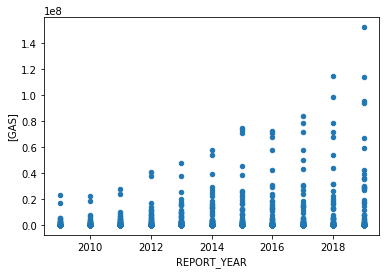

In [25]:
df_NDYearlyAgg_Production.plot(x='REPORT_YEAR',y=['GAS'], kind='scatter' )

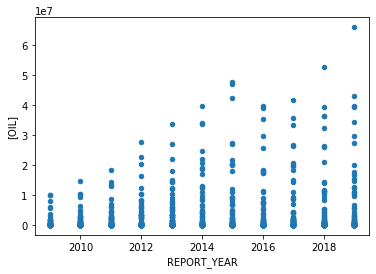

In [26]:
df_NDYearlyAgg_Production.plot(x='REPORT_YEAR',y=['OIL'], kind='scatter' )